# Proyecto Final RAG

La estructura del RAG es relativamente simple:
1. instalacción de bibliotecas e importación de las bibliotecas instaladas
2. carga de API-keys de OpenAI
3. Cargar base de datos con texto sin embeddings
4. Generar embeddings
5. Definir funciones especificas para realizar la busqueda, definir el mensaje de respuesta
6. Realizar la busqueda.

Este script es la cuarta iteración del RAG. Cada uno de los RAGs previos tuvo errores inaceptables.

*   El T-1, era muy complejo y no entendía bien porque hacía ciertas cosas.
*   El T-2, rehecho desde cero, no corría nada.
*   El T-3 corría pero casi el 90% de sus respuestas eran exclusivamente de CHATGPT.


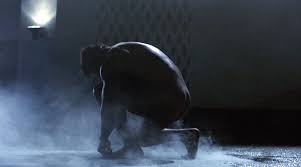

In [1]:
# Instalar las bibliotecas necesarias
!pip install tiktoken openai==0.28 pandas

# Importar las bibliotecas necesarias
import pandas as pd
import openai
from scipy.spatial.distance import cosine
import tiktoken


You should consider upgrading via the 'C:\Users\iparedes\Desktop\WPy64-39100\python-3.9.10.amd64\python.exe -m pip install --upgrade pip' command.


In [3]:
# Configurar tu API key de OpenAI
openai.api_key = ('Insertar_API_KEY_openAI')

In [3]:
# Cargar el CSV en un DataFrame de pandas
articulos = pd.read_csv('combined_pdf_paragraphs_utf8.csv', encoding='utf-8')

# Mostrar las primeras filas del DataFrame
articulos.head()

,Paragraph
0,International Review of Financial Analysis 87 ...
1,The impact of the Russian-Ukrainian war on glo...
2,"1. Introduction On February 24, 2022 Russia i..."
3,"Countries in Europe, Central Asia, the Middle ..."
4,Ukraine's exports of seed oil account for 40% ...


Definimos la función para crear embeddings, el modelo seleccionado es: [text-embedding-ada-002](https://openai.com/index/new-and-improved-embedding-model/).


In [4]:
# Definir la función para obtener embeddings
def get_embedding(text):
    response = openai.Embedding.create(input=[text], model='text-embedding-ada-002')
    return response['data'][0]['embedding']


Generar embeddings para la columna "Paragraph"

In [5]:
# Generar embeddings para la columna "description"
articulos['embedding'] = articulos['Paragraph'].apply(get_embedding)

Observamos como quedo la base de datos (dataframe), cada palabra tiene un valor asignado en el embedding, este embedding es de aproximadamente 790 valores por línea.

In [6]:
# Mostrar el DataFrame con los embeddings
articulos.head()

,Paragraph,embedding
0,International Review of Financial Analysis 87 ...,"[-0.013146737590432167, -0.025407470762729645,..."
1,The impact of the Russian-Ukrainian war on glo...,"[-0.013931425288319588, -0.017247159034013748,..."
2,"1. Introduction On February 24, 2022 Russia i...","[-0.00010999373625963926, -0.03195354342460632..."
3,"Countries in Europe, Central Asia, the Middle ...","[0.025638267397880554, -0.01956670545041561, 0..."
4,Ukraine's exports of seed oil account for 40% ...,"[-0.0023299490567296743, -0.029597094282507896..."


Definir la función para buscar las descripciones más relacionadas. Se calcula su similitud con el embedding de la consulta utilizando la similitud coseno. El resultado se almacena en una nueva columna llamada similarity en el DataFrame df. Tengo entendido que podría usar otra medida de similitud, sin embargo esta medida se toma del [Comunidad OpenAI](https://community.openai.com/t/embeddings-utils-distance-formulas-where-did-it-move/479868)

In [8]:
# Definir la función para buscar las descripciones más relacionadas
def find_most_similar(query, df, top_n=5):
    query_embedding = get_embedding(query)
    df['similarity'] = df['embedding'].apply(lambda x: 1 - cosine(query_embedding, x))
    return df.nlargest(top_n, 'similarity')

Ejemplo de búsqueda


In [9]:
# Ejemplo de búsqueda
query = "Russia finance China"
top_matches = find_most_similar(query, articulos)

# Mostrar los resultados
for i, row in top_matches.iterrows():
    print(f"Descripción: {row['Paragraph']}")
    print(f"Similitud: {row['similarity']:.4f}\n")

Descripción: Oxford Analytica, 2022a. Russia-Ukraine war will impede Chinas economy. Emerald  Expert Briefings (oxan-db).
Similitud: 0.8360

Descripción: Meanwhile, those already with uneasy relations with the US may end up  as economic allies of Russia despite their military ties with Western al liances with NATO and the EU.
Similitud: 0.8339

Descripción: Russia will reduce its gas exports to the EU by 30%. S3 said that Russia retaliated against the EU energy ban. If the EU strictly enforced the prohibition of Russian coal exports, Russia would reduce its gas exports to the EU by 50% in retaliation for various EU sanctions. In the S4 scenario, if the EU has not prevented the escalation of the situation in Russia and Ukraine after pass- ing previous sanctions against Russia. The EU will increase the sanctions based on the original sanctions. The new sanctions in- clude related products such as crude oil and refined oil products.
Similitud: 0.8220

Descripción: Economic embargo against

Elegimos el modelo de Embedding y el LLM usado. Es importante que el modelo de embeddings usado para las busquedas y para la creación de los embeddings sea el mismo. Los primeros tres proyectos no me corrieron bien por esta razón.

In [10]:
# Modelo de embeddings y GPT usado
EMBEDDING_MODEL = 'text-embedding-ada-002'
GPT_MODEL = 'gpt-3.5-turbo'

Función para contar tokens en un texto. La tokenización es el proceso de dividir el texto en unidades más pequeñas llamadas "tokens".

In [11]:
# Función para contar tokens en un texto
def num_tokens(text: str, model: str = GPT_MODEL) -> int:
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))

Función para obtener embeddings

In [12]:
# Función para obtener embeddings
def get_embedding(text):
    response = openai.Embedding.create(input=[text], model=EMBEDDING_MODEL)
    return response['data'][0]['embedding']

Función para encontrar las descripciones más relacionadas


In [13]:
# Función para encontrar las descripciones más relacionadas
def strings_ranked_by_relatedness(
    query: str,
    df: pd.DataFrame,
    relatedness_fn=lambda x, y: 1 - cosine(x, y),
    top_n: int = 100
) -> tuple[list[str], list[float]]:
    query_embedding = get_embedding(query)
    strings_and_relatednesses = [
        (row["Paragraph"], relatedness_fn(query_embedding, row["embedding"]))
        for i, row in df.iterrows()
    ]
    strings_and_relatednesses.sort(key=lambda x: x[1], reverse=True)
    strings, relatednesses = zip(*strings_and_relatednesses)
    return strings[:top_n], relatednesses[:top_n]

Función para generar el mensaje de consulta

In [14]:
# Función para generar el mensaje de consulta
def query_message(
    query: str,
    df: pd.DataFrame,
    model: str,
    token_budget: int
) -> str:
    strings, relatednesses = strings_ranked_by_relatedness(query, df)
    introduction = 'Use the below descriptions to answer."'
    question = f"\n\nQuestion: {query}"
    message = introduction
    for string in strings:
        next_article = f'\n\nDescription:\n"""\n{string}\n"""'
        if (
            num_tokens(message + next_article + question, model=model)
            > token_budget
        ):
            break
        else:
            message += next_article
    return message + question


Función para hacer la consulta y obtener la respuesta


In [15]:
# Función para hacer la consulta y obtener la respuesta
def ask(
    query: str,
    df: pd.DataFrame,
    model: str = "gpt-3.5-turbo",
    token_budget: int = 4096 - 500,
    print_message: bool = False,
) -> str:
    message = query_message(query, df, model=model, token_budget=token_budget)
    if print_message:
        print(message)
    messages = [
        {"role": "system", "content": "You answer questions about the War in Ukrania."},
        {"role": "user", "content": message},
    ]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0
    )
    response_message = response['choices'][0]['message']['content']

    # Extraer solo la parte relevante de la respuesta
    start_index = response_message.find("Question:")
    if start_index != -1:
        response_message = response_message[start_index:]

    # Filtrar para obtener solo la respuesta relevante después de la pregunta
    question_end_index = response_message.find("\n", start_index)
    if question_end_index != -1:
        response_message = response_message[question_end_index:].strip()

    return response_message

In [16]:
# Hacer una consulta
query = "What are the consecuences of the war for Ucrania?"
response = ask(query, articulos, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
While each conflict has had its unique consequences, they have all  resulted in a surge in the number of refugees. This has also been the case  in Ukraine. Over eight million refugees have moved to Europe so far and  even larger numbers were forced to relocate domestically. Evidence  from Poland and UK suggests that these refugees are able to secure jobs  and integrate to Europes labor force (Bird & Noumon, 2022). Other  common consequences naturally include reduced foreign investment,  trade restrictions, damage to reputation in the global arena, security  risks, exits by foreign businesses, and disrupted supply chains, all of  which have already been observed in the Russo-Ukrainian war.
"""

Description:
"""
Against this backdrop, we anticipate eight consequences of a pro longed conflict in Ukraine: 1. competition gives way to cartelization, 2.
"""

Description:
"""
1. Introduction The Russian invasion of Ukraine has caused con

In [17]:
# Hacer una consulta
query = "what are the The impact of the Russian-Ukrainian war on global financial markets?"
response = ask(query, articulos, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
The impact of the Russian-Ukrainian war on global financial markets  Marwan Izzeldin a, Yaz Glnur Murado glu b, Vasileios Pappas c,*, Athina Petropoulou d,  Sheeja Sivaprasad e  a Lancaster University, Lancaster LA1 4YW, UK  b Queen Mary University of London, E1 4NS UK  c University of Kent, Kent ME4 4TE, UK  d SOAS University of London, WC1H 0XG, UK  e University of Westminster, London NW1 5LS, UK    A R T I C L E  I N F O    JEL classification:  G15  C24  Keywords:  Ukraine war  Financial markets  HAR  Markov switching  Commodities  A B S T R A C T    On February 24, 2022, Russia invaded the Ukraine. In this paper, we analyze the response of European and global  stock markets alongside a representative sample of commodities. We compare the war response against the  recent Covid-19 pandemic and the not-too-distant 2008 global financial crisis. Applying a Markov-switching  HAR model on volatility proxies, estimates are made of sy

In [18]:
# Hacer una consulta
query = "what are the sanctions apply to Russia for his military intervention?"
response = ask(query, articulos, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
The Russia Ukraine conflict has led to several rounds of sanctions in the Western world, mainly the United States and the European Union, including individual, economic, and financial sanctions (Chepeliev et al., 2022; Mahlstein et al., 2022). The sanctions are aimed at weakening Russias economy, making it unable to pay for its high military spending, and forcing Russia out of Ukraine.
"""

Description:
"""
The most important of the measures should be sanctions on Russias energy trade. The consequences of the energy sanctions imposed by Western countries against Russia significantly impact the economy and society of the EU and Russia more than other stakeholders. This is mainly because the EU is highly dependent Corresponding author.
"""

Description:
"""
Economic embargo against Russia has not achieved devastating  impact and Russia remains unwilling to give up her claims in  Ukraine. Russian conflicts elsewhere have persisted. 

In [19]:
# Hacer una consulta
query = "what Does Xi-Yin Zhou think about the war?"
response = ask(query, articulos, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
X.-Y. Zhou et al.
"""

Description:
"""
X.-Y. Zhou et al.
"""

Description:
"""
X.-Y. Zhou et al.
"""

Description:
"""
X.-Y. Zhou et al.
"""

Description:
"""
Leigh, A., Wolfers, J., & Zitzewitz, E. (2003). What do financial markets think of war in  Iraq?. In NBER working paper W9587.
"""

Description:
"""
Leigh, A., Wolfers, J., & Zitzewitz, E. (2003). What do financial markets think of war in  Iraq?. In NBER working paper W9587.
"""

Description:
"""
Oxford Analytica, 2022a. Russia-Ukraine war will impede Chinas economy. Emerald  Expert Briefings (oxan-db).
"""

Description:
"""
Gong, X., Sun, Y., Du, Z., 2022. Geopolitical risk and Chinas oil security. Energy Policy 163, 112856. http://dx.doi.org/10.1016/J.ENPOL.2022.112856.
"""

Description:
"""
Science of the Total Environment 902 (2023) 166122 8 3.4. Implications for management  The impacts of this war on the environment are largely uncertain.
"""

Description:
"""
Y. Chen